<a href="https://colab.research.google.com/github/MrKozelberg/wavefunction_perceptron/blob/spectrum_laplace_operator/spectrum_laplace_operator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying the perceptron to the Laplace operator's eigen-problem

## Imports

In [368]:
import numpy as np  # to work with arrays
import matplotlib.pyplot as plt  # to make figures

# PyTorch
import torch
from torch import nn

## Detect available device

In [366]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Definition of an activation function and its derivatives

In [367]:
def f0(x):
    return torch.tanh(x)
  
def f1(x):
  return 1/torch.cosh(x)**2
  
def f2(x):
  return -2*torch.sinh(x)/torch.cosh(x)**3

## Class for the perceptron-wavefunction 

In [369]:
class WaveFunction(nn.Module):

  def __init__(self, N, layersizes):
    self.N = N  # size of the input vector
    self.layersizes = layersizes  # sizes of hidden layers
    self.l = len(self.layersizes)  # number of hidden layers

    super(WaveFunction, self).__init__()
        
    self.linear_tanh_stack = nn.Sequential()
    for i in range(self.l + 1):
      if i == 0:
        self.linear_tanh_stack.append(nn.Linear(N, self.layersizes[i]))
      elif i == self.l:
        self.linear_tanh_stack.append(nn.Linear(self.layersizes[i-1], 1))
      else:
        self.linear_tanh_stack.append(nn.Linear(self.layersizes[i-1],
                                                self.layersizes[i]))
      self.linear_tanh_stack.append(nn.Tanh())
    
    self.h = [None] * (self.l + 1)  # outputs of the layers

  
  def forward(self, x):
    for i in range(self.l + 1):
      if i == 0:
        self.h[i] = self.linear_tanh_stack[2*i+1](
            self.linear_tanh_stack[2*i](x))
      else:
        self.h[i] = self.linear_tanh_stack[2*i+1](
            self.linear_tanh_stack[2*i](self.h[i-1]))
      
    return self.h[-1]


  def grad(self, x):
    """
    finds the gradient of the wave function at a given point x
    """
    _ = self.forward(x)  # computes outputs of the layers #
    gradient = torch.zeros(x.shape) #[None] * self.N #
    for t in range(self.N):
      dh_dx = torch.zeros(self.N) #
      dh_dx[t] = 1 # 

      for i in range(self.l + 1):
        w = self.linear_tanh_stack[2*i].weight
        b = self.linear_tanh_stack[2*i].bias

        if i == 0:
          dh_dx = f1(x @ w.T + b) * (dh_dx @ w.T)
        else:
          dh_dx = f1(self.h[i-1] @ w.T + b) * (dh_dx @ w.T)   
        
      # print(dh_dx.shape, gradient[t].shape)
      
      gradient[:,t] = dh_dx.reshape(-1)

    return gradient
  

  def laplac(self, x):
    """
    finds the Laplacian of the wave function at a given point x
    """
    y = self.forward(x)  # computes outputs of the layers
    laplacian = 0.0
    for t in range(self.N):
      dh_dx = torch.zeros(self.N)
      dh_dx[t] = 1

      d2h_dx2 = torch.zeros(self.N)

      for i in range(self.l + 1):
        w = self.linear_tanh_stack[2*i].weight
        b = self.linear_tanh_stack[2*i].bias

        # firstly, the new value of the second derivative computes as it is 
        # used the previous value of the first derivative

        if i == 0:
          d2h_dx2 = f2(x @ w.T + b) * (dh_dx @ w.T)**2
        else:
          d2h_dx2 = f2(self.h[i-1] @ w.T + b) * (dh_dx @ w.T)**2\
                    + f1(self.h[i-1] @ w.T + b) * (d2h_dx2 @ w.T)

        if i == 0:
          dh_dx = f1(x @ w.T + b) * (dh_dx @ w.T)
        else:
          dh_dx = f1(self.h[i-1] @ w.T + b) * (dh_dx @ w.T) 
      
      # print(d2h_dx2)
      laplacian += d2h_dx2
    
    return laplacian

In [465]:
# def A(x_):
#   return torch.sum(torch.abs(x_ - 1/2) - 1/2, axis=1)
  
# def Ax(x_):
#   return 2*torch.sign(x_-1/2)
  
# def Axx(x_):
#   return 0.0

def A(x_):
  return torch.sum((x_ - 1/2)**2-1/4, axis=1)
  
def Ax(x_):
  return 2*(x_-1/2)
  
def Axx(x_):
  return 2.0

def train_loop(N, N_batch, M, wf, optimizer):
  """
  N --- a size of the input vector, its dimension
  M --- total number of iterations
  """

  loss_fn = nn.L1Loss()
  alpha = 1.0
  
  for i in range(M):
    x_test = torch.rand((N_batch, N), device=device)

    phi_test = wf(x_test).reshape(len(x_test))
    phix_test = wf.grad(x_test)
    phixx_test = wf.laplac(x_test).reshape(len(x_test))

    # если задавать нужное значение энергии, то всё получается
    # I = torch.mean((phixx_test * A(x_test) + 2 * torch.sum(Ax(x_test) * phix_test, axis=1) + Axx(x_) * phi_test + np.pi**2*phi_test*A(x_test))**2)

    I = -torch.mean((phixx_test * A(x_test) + 2 * torch.sum(Ax(x_test) * phix_test, axis=-1) + Axx(x_) * phi_test)/(phi_test*A(x_test))) + alpha * (torch.mean(torch.sum((phi_test*A(x_test))**2, axis=-1)) - 1.0)

    # Compute loss
    loss = loss_fn(I, torch.tensor(0.0, device=device))

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 500 == 0:
      # print(f"Residual: {loss.item():>0.4E} [{i+1:>5d} / {M:>5d}]")
      print(f"Mean local energy: {torch.mean((phixx_test * A(x_test) + 2 * torch.sum(Ax(x_test) * phix_test, axis=-1) + Axx(x_) * phi_test)/(phi_test*A(x_test))):>0.4E} [{i+1:>5d} / {M:>5d}]")

      # print(f"Mean local energy: {loss.item():>0.4f}, Relative mean std error: {e_loc.std():>0.4f} [{i+1:>5d} / {M//N_batch:>5d}]")

## Our wavefunction

In [466]:
N = 1  # size of the input vector
wf = WaveFunction(N, [10]*4).to(device) ## число внутренних слоёв должно быть той же четности, что и номер состояния


 Epoch 1
-------------------------------
Mean local energy: NAN [  500 /  1000]
Mean local energy: NAN [ 1000 /  1000]


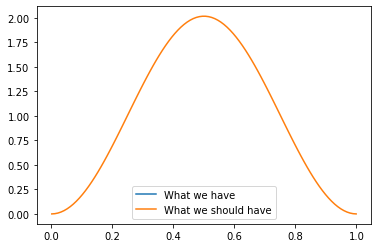


 Epoch 2
-------------------------------
Mean local energy: NAN [  500 /  1000]


KeyboardInterrupt: ignored

In [467]:
optimizer = torch.optim.SGD(params = wf.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
epochs = 50
for t in range(epochs):
  print(f"\n Epoch {t+1}\n-------------------------------")
  train_loop(N, 20*(t+10)//10, 1000, wf, optimizer)
  scheduler.step()

  if (t + 1) % 10 == 0 or t == 0:
    x_ = torch.linspace(0+1e-3,1-1e-3,100, device=device).reshape(100,1)
    # y_ = wf(x_).detach().numpy() * A(x_.detach().numpy())
    # plt.plot(x_, wf(x_).detach().numpy() / wf(x_).detach().numpy().mean(), label='What we have')
    # plt.plot(x_, (torch.sin(x_*np.pi).reshape(-1) / A(x_).reshape(-1) / torch.mean(torch.sin(x_*np.pi).reshape(-1) / A(x_).reshape(-1))).detach().numpy(), label='What we should have')

    y_ = (wf(x_).reshape(-1) * A(x_).reshape(-1)).detach().numpy()**2
    plt.plot(x_, y_/ y_.mean(), label='What we have')
    plt.plot(x_, ((torch.sin(x_*np.pi)**2).reshape(-1) / torch.mean((torch.sin(x_*np.pi)**2).reshape(-1))).detach().numpy(), label='What we should have')

    plt.legend()
    # plt.title("A(x)")
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: The following kwargs were not used by contour: 'label'
  if __name__ == '__main__':


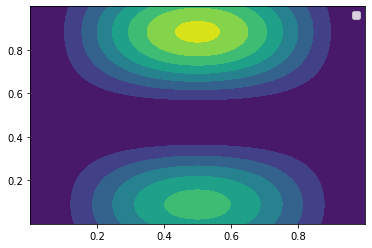

In [413]:
x_ = torch.linspace(0+1e-3,1-1e-3,100, device=device).reshape(100,1)

x_ = torch.vstack((x_.T, x_.T)).T
    # y_ = wf(x_).detach().numpy() * A(x_.detach().numpy())
    # plt.plot(x_, wf(x_).detach().numpy() / wf(x_).detach().numpy().mean(), label='What we have')
    # plt.plot(x_, (torch.sin(x_*np.pi).reshape(-1) / A(x_).reshape(-1) / torch.mean(torch.sin(x_*np.pi).reshape(-1) / A(x_).reshape(-1))).detach().numpy(), label='What we should have')

y_ = (wf(x_) * A(x_)).detach().numpy()**2
plt.contourf(x_[:,0], x_[:,1], y_/ y_.mean(), label='What we have')

plt.legend()
# plt.title("A(x)")
plt.show()